In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os
import common

In [2]:
# Reproducibility
common.set_seed(1)

In [3]:
class DividedPlane(torch.utils.data.Dataset):
    def __init__(self, n=100, noise=0.1, seed=None):
        a = torch.tensor([0.4, 0.5, 0.15]) #torch.rand((3,))
        def myfunc(x):
            y = a[0]*x[:,0] + a[1]*x[:,1] + a[2]
            return y
        self.x = torch.rand((n,2))*2. - 1.
        y = myfunc(self.x) + noise*torch.normal( torch.zeros((len(self.x))) )
        self.y = (y>0.).type(torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.y.reshape( (len(self.y),1) )
    
    def plot(self, labels=None, *args, **kwargs): 
        X = self.inputs()
        if labels is None:
            labels = self.targets()
        colour_options = [(1,0,0),(0,1,0)]
        if len(labels[0])>1:
            # one-hot labels
            cidx = torch.argmax(labels, axis=1)
        else:
            # binary labels
            cidx = (labels>0.5).type(torch.int)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,0].detach(), X[:,1].detach(), color=colours, marker='.')

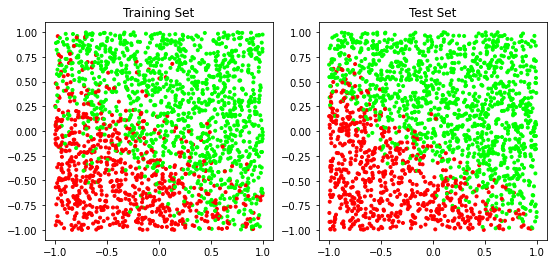

In [4]:
train = DividedPlane(n=2000, noise=0.2, seed=265)
test = DividedPlane(n=2000)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); train.plot(); plt.title(f'Training Set');
plt.subplot(1,2,2); test.plot(); plt.title(f'Test Set');

In [5]:
train.inputs().shape

torch.Size([2000, 2])

In [6]:
class NN(torch.nn.Module):
    def __init__(self, ni, nh, no):
        super(NN, self).__init__()
        self.A = torch.nn.Linear(ni, nh)
        self.relu = torch.nn.ReLU()
        self.B = torch.nn.Linear(nh, no)
    def forward(self, x):
        # Two layer neural network
        x = self.B(self.relu(self.A(x)))
        return x

In [7]:
net = NN(2, 100, 2)

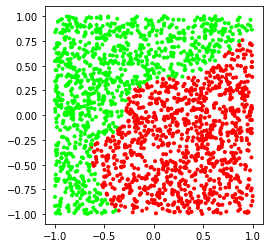

In [9]:
plt.gca().set_aspect('equal', adjustable='box'); test.plot(labels=net(test.inputs()))

In [10]:
def model(x, y):
    # Put priors on weights and biases 
    priors = {
        "A.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.weight), 
            scale=torch.ones_like(net.A.weight),
        ).independent(2),
        "A.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.A.bias), 
            scale=torch.ones_like(net.A.bias),
        ).independent(1),
        "B.weight": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.weight), 
            scale=torch.ones_like(net.B.weight),
        ).independent(2),
        "B.bias": pyro.distributions.Normal(
            loc=torch.zeros_like(net.B.bias), 
            scale=torch.ones_like(net.B.bias),
        ).independent(1),
    }
    # Create a NN module using the priors
    lmodule = pyro.random_module("module", net, priors)
    regressor = lmodule()
    # Do a forward pass on the NN module, i.e. yhat=f(x) and condition on yhat=y
    lhat = torch.nn.LogSoftmax(dim=1)(regressor(x))
    # print(pyro.distributions.Categorical(logits=lhat).sample(), y)
    pyro.sample("obs", pyro.distributions.Categorical(logits=lhat).independent(1), obs=y.view(-1))

In [11]:
softplus = torch.nn.Softplus()
def guide(x, y):
    # Create parameters for variational distribution priors
    Aw_mu = pyro.param("Aw_mu", torch.randn_like(net.A.weight))
    Aw_sigma = softplus(pyro.param("Aw_sigma", torch.randn_like(net.A.weight)))
    Ab_mu = pyro.param("Ab_mu", torch.randn_like(net.A.bias))
    Ab_sigma = softplus(pyro.param("Ab_sigma", torch.randn_like(net.A.bias)))
    Bw_mu = pyro.param("Bw_mu", torch.randn_like(net.B.weight))
    Bw_sigma = softplus(pyro.param("Bw_sigma", torch.randn_like(net.B.weight)))
    Bb_mu = pyro.param("Bb_mu", torch.randn_like(net.B.bias))
    Bb_sigma = softplus(pyro.param("Bb_sigma", torch.randn_like(net.B.bias)))
    # Create random variables similarly to model
    priors = {
        "A.weight": pyro.distributions.Normal(loc=Aw_mu, scale=Aw_sigma).independent(2),
        "A.bias": pyro.distributions.Normal(loc=Ab_mu, scale=Ab_sigma).independent(1),
        "B.weight": pyro.distributions.Normal(loc=Bw_mu, scale=Bw_sigma).independent(2),
        "B.bias": pyro.distributions.Normal(loc=Bb_mu, scale=Bb_sigma).independent(1),
    }
    # Return NN module from these random variables
    lmodule = pyro.random_module("module", net, priors)
    return lmodule()

In [12]:
# Do stochastic variational inference to find q(w) closest to p(w|D)
svi = pyro.infer.SVI(
    model, guide, pyro.optim.Adam({'lr': 0.01}), pyro.infer.Trace_ELBO(),
)

In [13]:
def train_and_save_models(epochs = 10, K = 100, modelname = "model-2d.pt"):
    if os.path.exists(modelname):
        print("File exists")
        return
    # Train with SVI
    for epoch in range(epochs):
        loss = 0.
        images, labels = train.inputs(), train.targets()
        loss += svi.step(images, labels)
        loss /= len(labels)
        print("Epoch %g: Loss = %g" % (epoch, loss))
    # Sample k models from the posterior
    sampled_models = [guide(None, None) for i in range(K)]
    # Save the models
    nn_dicts = []
    for i in range(len(sampled_models)):
        nn_dicts += [sampled_models[i].state_dict()]
    torch.save(nn_dicts, modelname)
    print("Saved %d models" % K)

In [14]:
def load_models(K = 100):
    # Load the models
    sampled_models = [NN(2, 100, 2) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load("model-2d.pt")):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models

In [15]:
train_and_save_models(epochs = 100, K = 100, modelname = "model-2d.pt")
sampled_models = load_models(K = 100)

File exists
Loaded 100 sample models


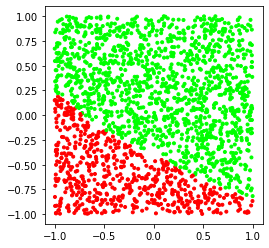

In [16]:
plt.gca().set_aspect('equal', adjustable='box'); test.plot(labels=sampled_models[33](test.inputs()))

In [155]:
def show_bnn_decisions(test, sampled_models, curr_image = None, adv_images = None, agg_image = None):
    X = test.inputs()
    labels = sampled_models[33](test.inputs())
    colour_options = [(0,0,0),(1,0,0)]
    cidx = torch.argmax(labels, axis=1)
    colours = [colour_options[k] for k in cidx]
    pts1, pts2, pts3, pts4 = [], [], [], []
    for xi in tqdm.tqdm(range(len(X))):
        x = X[xi, :].view(1, 2)
        s1, s2, s3 = 0, 0, 0
        for sm in sampled_models:
            if torch.argmax(sm(x), axis=1).item() == 1: 
                s1 += 1
                s2 += 0
            else:
                s2 += 1
                s1 += 0
        if s2 == 100:
            pts2 += [x]
        if s1 == 100:
            pts1 += [x]
        if 25 <= s1 <= 50:
            pts3 += [x]
        if 25 <= s2 <= 50:
            pts4 += [x]
        colours[xi] = (s2/100., s1/100., 0)
    from scipy.spatial import ConvexHull
    p1 = np.stack(pts1).squeeze(1)
    p2 = np.stack(pts2).squeeze(1)
    p3 = np.stack(pts3).squeeze(1)
    p4 = np.stack(pts4).squeeze(1)
    hull1 = ConvexHull(p1)
    hull2 = ConvexHull(p2)
    hull3 = ConvexHull(p3)
    hull4 = ConvexHull(p4)
    for simplex in hull1.simplices:
        plt.plot(p1[simplex, 0], p1[simplex, 1], 'k-')
    for simplex in hull2.simplices:
        plt.plot(p2[simplex, 0], p2[simplex, 1], 'k-')
    for simplex in hull3.simplices:
        plt.plot(p3[simplex, 0], p3[simplex, 1], 'k-')
    for simplex in hull4.simplices:
        plt.plot(p4[simplex, 0], p4[simplex, 1], 'k-')
    plt.scatter(X[:,0].detach(), X[:,1].detach(), color=colours, marker='.')
    if adv_images != None: 
        plt.scatter(torch.stack(adv_images).squeeze(1)[:, 0].detach(),\
                torch.stack(adv_images).squeeze(1)[:, 1].detach(), color=(0,0,1), marker='s')
    if curr_image != None:
        plt.scatter(curr_image[:, 0].detach(), curr_image[:, 1].detach(),\
                color=(0,0,1), marker='P')
    if agg_image != None:
        agg_image = agg_image.view(1, 2)
        plt.scatter(agg_image[:, 0].detach(), agg_image[:, 1].detach(),\
                color=(0,0,0), marker='*')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [149]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

In [150]:
def otcm(images, eps, saliency):
    return torch.clamp(images.clone()-eps*saliency, -1, 1)

In [151]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, eps, saliency):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
        # One step Target Class Method (OTCM); saliency is noise
        new_images = otcm(images, eps, saliency)
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        # If we change the class, we fool the model
        fool += int(old_class != new_class)
    return fool/len(sampled_models)

In [152]:
# Collect noises (saliencies)
def get_images(EPS):
    saliencies = []
    how_many_fooled = []
    torch.set_printoptions(sci_mode=False)
    curr_image = torch.clone(images)
    adv_images = []
    for k in range(len(sampled_models)):
        # Forward pass
        # Compute loss w.r.t. an incorrect class
        # Note that we just have to ensure this class is different from targets
        images.grad = None
        images.requires_grad = True
        old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), torch.tensor([1])])
        # Compute adversarial example
        new_images = otcm(images, EPS, images.grad.sign())
        adv_images += [new_images]
        # Forward pass on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        if old_class != new_class:
            # How many models can this adv. example fool?
            how_many_fooled += [how_many_can_it_fool(sampled_models, EPS, images.grad.sign())]
            saliencies += [images.grad.sign().view(2)]
    # distributional saliency map
    saliencies = torch.stack(saliencies)
    print(saliencies.shape)
    newsaliency = torch.zeros(2)
    for i in range(2):
        # choose median perturbation
        newsaliency[i] = np.percentile(saliencies[:, i].numpy(), 50)
    print('agg', how_many_can_it_fool(sampled_models, EPS, newsaliency))
    new_images = otcm(images, EPS, newsaliency)
    print('mean indiv', np.mean(how_many_fooled))
    return curr_image, adv_images, new_images

100%|██████████| 2000/2000 [00:23<00:00, 85.10it/s]


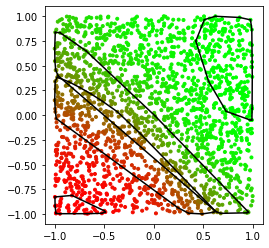

In [153]:
show_bnn_decisions(test, sampled_models)

  0%|          | 0/2000 [00:00<?, ?it/s]

tensor([[ 0.9441, -0.0170]]) tensor([0.])
torch.Size([1, 2])
agg 0.76
mean indiv 0.76


100%|██████████| 2000/2000 [00:23<00:00, 85.85it/s]


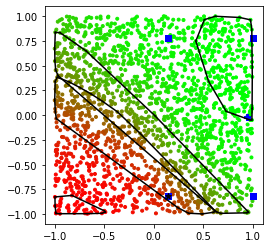

In [157]:
images, targets = pts1[np.random.choice(len(pts1))], torch.tensor([0.])
print(images, targets)
show_bnn_decisions(test, sampled_models, *get_images(0.8))

tensor([[-0.7715, -0.8755]]) tensor([0.])


  0%|          | 6/2000 [00:00<00:38, 51.37it/s]

torch.Size([69, 2])
agg 0.69
mean indiv 0.6621739130434781


100%|██████████| 2000/2000 [00:26<00:00, 74.63it/s]


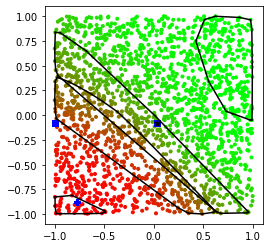

In [159]:
images, targets = pts2[np.random.choice(len(pts2))], torch.tensor([0.])
print(images, targets)
show_bnn_decisions(test, sampled_models, *get_images(0.8))

tensor([[-0.1813, -0.1646]]) tensor([0.])


  0%|          | 7/2000 [00:00<00:31, 63.44it/s]

torch.Size([53, 2])
agg 0.54
mean indiv 0.5283018867924527


100%|██████████| 2000/2000 [00:23<00:00, 85.15it/s]


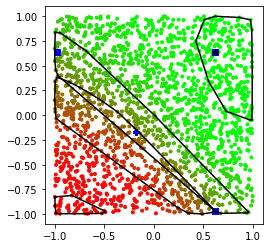

In [161]:
images, targets = pts3[np.random.choice(len(pts3))], torch.tensor([0.])
print(images, targets)
show_bnn_decisions(test, sampled_models, *get_images(0.8))

tensor([[-0.7737,  0.4406]]) tensor([0.])


  0%|          | 9/2000 [00:00<00:23, 84.85it/s]

torch.Size([32, 2])
agg 0.32
mean indiv 0.32


100%|██████████| 2000/2000 [00:23<00:00, 83.78it/s]


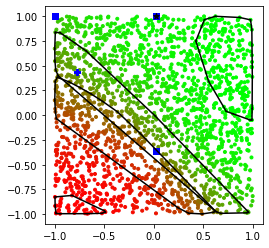

In [162]:
images, targets = pts4[np.random.choice(len(pts4))], torch.tensor([0.])
print(images, targets)
show_bnn_decisions(test, sampled_models, *get_images(0.8))

tensor([[-0.6965,  0.6113]]) tensor([0.])


  0%|          | 7/2000 [00:00<00:30, 66.08it/s]

torch.Size([21, 2])
agg 0.21
mean indiv 0.21000000000000002


100%|██████████| 2000/2000 [00:24<00:00, 81.93it/s]


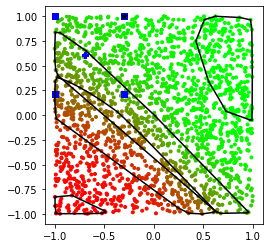

In [163]:
images, targets = pts4[np.random.choice(len(pts4))], torch.tensor([0.])
print(images, targets)
show_bnn_decisions(test, sampled_models, *get_images(0.4))